# Homework3 - datatalks.club - Rui Pinto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# getting the data
#!curl -O https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
#!unzip bank+marketing.zip
#!unzip bank.zip

In [3]:
#loading the data
df = pd.read_csv('bank-full.csv', sep=';')

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Data Preparation

Features
For the rest of the homework, you'll need to use only these columns:

age,
job,
marital,
education,
balance,
housing,
contact,
day,
month,
duration,
campaign,
pdays,
previous,
poutcome,
y

In [5]:
# features and target
X = df.drop(columns=["default","loan","y"])
y = df["y"] #target

In [6]:
# checking for missing values
X.isnull().sum() #no missing values

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

## Question 1

What is the most frequent observation (mode) for the column education?

- unknown
- primary
- secondary
- tertiary

In [7]:
print(f"The most frequent observation (mode) for column education is: {X['education'].mode()[0]}")

The most frequent observation (mode) for column education is: secondary


## Question 2
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?

- age and balance
- day and campaign
- day and pdays
- pdays and previous

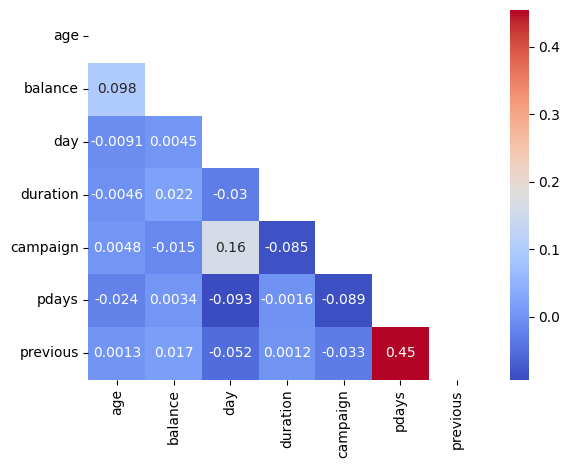

In [8]:
X_num = X.select_dtypes(include=[np.number])
X_cat = X.select_dtypes(include=[object])

# check for for the two highest correlated features
corr = X_num.corr()
# heatmap with only half of the values
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm')
plt.show()

In [9]:
# all correlation pairs in a dataframe sorted by absolute correlation without duplicates
corr_pairs = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()
corr_pairs = corr_pairs[corr_pairs != 1]
pd.DataFrame(corr_pairs, columns=["correlation"]).style.background_gradient(cmap='coolwarm')

In [10]:
print(f"The highest correlated features are: {corr_pairs.index[0]}")

The highest correlated features are: ('previous', 'pdays')


### Target encoding
- Now we want to encode the y variable.
- Let's replace the values yes/no with 1/0.

In [11]:
# encode target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

### Split the data
- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value y is not in your dataframe.

In [12]:
from sklearn.model_selection import train_test_split

# split data into train/val/test with 60%/20%/20% ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


## Question 3

Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only.
Round the scores to 2 decimals using round(score, 2).
Which of these variables has the biggest mutual information score?

- contact
- education
- housing
- poutcome

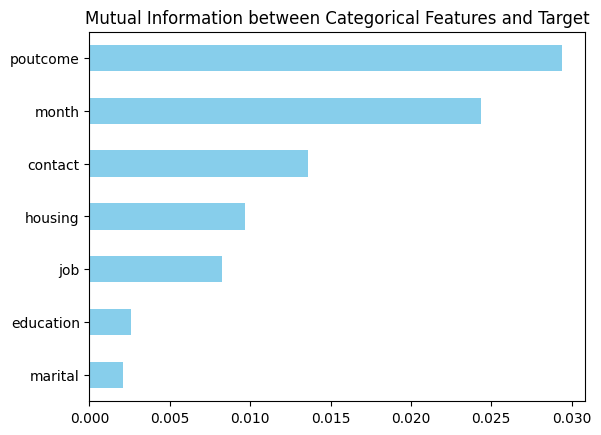

In [13]:
from sklearn.metrics import mutual_info_score

# calculate mutual information cat variable and target
mi = X_cat.apply(lambda x: mutual_info_score(x, y))
mi.sort_values().plot(kind='barh', color='skyblue').set_title('Mutual Information between Categorical Features and Target')
plt.show()

In [14]:
print(f"The highest mutual information between a categorical feature and the target is: {mi.max()} for the feature: {mi.idxmax()}")

The highest mutual information between a categorical feature and the target is: 0.029397241496458754 for the feature: poutcome


## Question 4

- Now let's train a logistic regression.
- Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
- Fit the model on the training dataset.
  - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
  - model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

- 0.6
- 0.7
- 0.8
- 0.9

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


# create a pipeline for the model
preprocessor = ColumnTransformer([
    ('num', 'passthrough', X_num.columns),
    ('cat', OneHotEncoder(), X_cat.columns)
])

model = make_pipeline(preprocessor, LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))

model


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['job', 'marital', 'education', 'housing', 'contact', 'month',
       'poutcome'],
      dtype='object'))])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='liblinear'))])

In [16]:
# fit model
model.fit(X_train, y_train)

# predict on validation set
y_pred = model.predict(X_val)

from sklearn.metrics import accuracy_score

# calculate accuracy
accuracy = round(accuracy_score(y_val, y_pred),2)

print(f"The accuracy of the model is: {accuracy}")


The accuracy of the model is: 0.9


## Question 5

- Let's find the least useful feature using the feature elimination technique.
- Train a model with all these features (using the same parameters as in Q4).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?

- age
- balance
- marital
- previous

Note: The difference doesn't have to be positive.

In [17]:
X_train

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
20326,32,technician,single,tertiary,1100,yes,cellular,11,aug,67,1,-1,0,unknown
24301,38,entrepreneur,married,secondary,0,yes,cellular,17,nov,258,1,-1,0,unknown
38618,49,blue-collar,married,secondary,3309,yes,cellular,15,may,349,2,-1,0,unknown
18909,37,housemaid,married,primary,2410,no,cellular,4,aug,315,1,-1,0,unknown
23081,31,self-employed,married,tertiary,3220,no,cellular,26,aug,74,4,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13264,27,services,single,secondary,167,no,cellular,8,jul,606,2,-1,0,unknown
28829,40,technician,single,tertiary,693,no,cellular,30,jan,427,1,-1,0,unknown
3844,54,technician,divorced,secondary,0,yes,unknown,16,may,161,1,-1,0,unknown
15597,25,services,single,secondary,2311,no,cellular,21,jul,1105,2,-1,0,unknown


In [18]:
# train model again with feature elimination one by one, calculate accuracy and store in a list
accuracies = {}

for feature in X.columns:
    X_train_temp = X_train.drop(columns=feature)
    X_val_temp = X_val.drop(columns=feature)
    
    # Update the preprocessor to match the new columns
    preprocessor = ColumnTransformer([
        ('num', 'passthrough', X_train_temp.select_dtypes(include=[np.number]).columns),
        ('cat', OneHotEncoder(), X_train_temp.select_dtypes(include=[object]).columns)
    ])
    
    model = make_pipeline(preprocessor, LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
    
    model.fit(X_train_temp, y_train)
    y_pred = model.predict(X_val_temp)
    
    accuracy_elimination = accuracy_score(y_val, y_pred)
    
    # Store the accuracy in a dictionary
    # For each feature, calculate the difference between the original accuracy and the accuracy without the feature
    accuracies[feature] = accuracy - accuracy_elimination

# sorted dictionary
sorted_accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1], reverse=True))

In [19]:
# select only the features difference
features = ['age', 'balance', 'marital', 'previous']

# get the differences of removing the features
difference = {feature: sorted_accuracies[feature] for feature in features}

print(f"The difference of removing the features is: {difference}") 

# Which of following feature has the smallest difference?
print(f"The feature with the smallest difference is: {max(difference, key=difference.get)}")

The difference of removing the features is: {'age': -0.0003539040035389629, 'balance': -0.0013492590134925875, 'marital': -0.0009068790090687173, 'previous': -0.0010174740101747126}
The feature with the smallest difference is: age


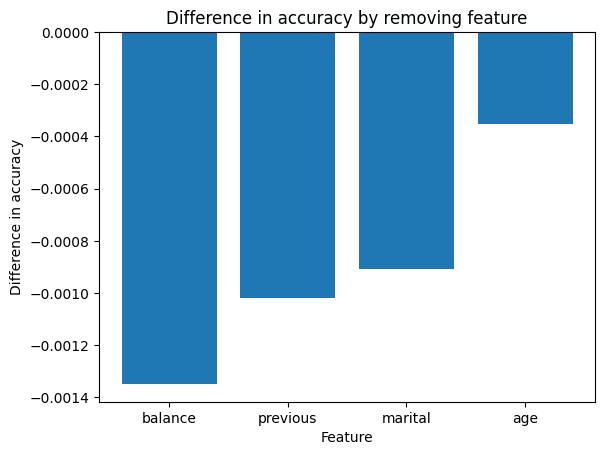

In [20]:
# Sort the differences by values
sorted_difference = dict(sorted(difference.items(), key=lambda item: item[1]))

# Plot the sorted differences
plt.bar(sorted_difference.keys(), sorted_difference.values())
plt.ylabel('Difference in accuracy')
plt.xlabel('Feature')
plt.title('Difference in accuracy by removing feature')
plt.show()

## Question 6
- Now let's train a regularized logistic regression.
- Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
- Train models using all the features as in Q4.
- Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

Which of these C leads to the best accuracy on the validation set?

- 0.01
- 0.1
- 1
- 10
- 100

Note: If there are multiple options, select the smallest C.

In [21]:
C = [0.001, 0.01, 0.1, 1, 10, 100]


# train model again with different C values, calculate accuracy and store in a list
accuracies = {}

for c in C:
    preprocessor = ColumnTransformer([
        ('num', 'passthrough', X_train.select_dtypes(include=[np.number]).columns),
        ('cat', OneHotEncoder(), X_train.select_dtypes(include=[object]).columns)
    ])
    
    model = make_pipeline(preprocessor, LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42))
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    accuracy_c = round(accuracy_score(y_val, y_pred),3)
    
    # Store the accuracy in a dictionary
    accuracies[c] = accuracy_c
    
# sorted dictionary
sorted_accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1], reverse=True))

In [22]:
sorted_accuracies

{0.1: 0.901, 1: 0.901, 10: 0.901, 100: 0.901, 0.01: 0.898, 0.001: 0.891}

In [106]:
print(f"The accuracy of the model with the best C value is: {max(sorted_accuracies, key=sorted_accuracies.get)}")

The accuracy of the model with the best C value is: 0.1
